In [1]:
import numpy as np
import pandas as pd
import os

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

In [2]:
myfolder = 'F:/rs/Recommender_DNN/input/'


print('loading files ...')

prior = pd.read_csv(myfolder + 'order_products__prior.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.uint8, 'add_to_cart_order': np.uint8})

train_orders = pd.read_csv(myfolder + 'order_products__train.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.int8, 'add_to_cart_order': np.uint8 })

orders = pd.read_csv(myfolder + 'orders.csv', dtype={'order_hour_of_day': np.uint8,
           'order_number': np.uint8, 'order_id': np.uint32, 'user_id': np.uint32,
           'order_dow': np.uint8, 'days_since_prior_order': np.float16})

orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.uint8)
orders.days_since_prior_order = orders.days_since_prior_order.fillna(30).astype(np.uint8)

products = pd.read_csv(myfolder + 'products.csv', dtype={'product_id': np.uint16,
            'aisle_id': np.uint8, 'department_id': np.uint8},
             usecols=['product_id', 'aisle_id', 'department_id'])

print('done loading')


print('merge prior and orders and keep train separate ...')

orders_products = orders.merge(prior, how = 'inner', on = 'order_id')
train_orders = train_orders.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')


del prior


loading files ...
done loading
merge prior and orders and keep train separate ...


# Feature Engineering
Usualy there are two popular approaches to solve top-N recommander systems:  
## User-based Approach:
Each person belongs in a larger group of similarly behaving individuals, items frequently purchased/liked by the various members of the group can be used to form the basis of the recommended items.  
## Product based Approach: 
analyzed the historical information to identify relations betwen the different items such that the purchase of an item(or a set of items) often lead to the purchase of another item(or a set if items).

## User Features
user_orders:User total orders  
user_period: How long has this user stayed since first user  
user_mean_days_since_prior: How often does this user make a order  
user_total_products  
user_distinct_products  
user_average_basket: How many items this user bought per order  
days_since_prior_order

In [3]:
# extracting prior information (features) by user
users = orders[orders['eval_set'] == 0].groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].mean()

# merging features about users and orders into one dataset
us = orders_products.groupby('user_id').size().to_frame('user_total_products')
us['eq_1'] = orders_products[orders_products['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_products[orders_products['order_number'] > 1].groupby('user_id')['product_id'].size()
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = orders_products.groupby(['user_id'])['product_id'].nunique()

# the average basket size of the user
users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

us = orders[orders['eval_set'] != 0]
us = us[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = users.merge(us)

del us
users.head()

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,10,206.0,20.600000,59,18,5.900000,1187899,1,14
1,2,14,228.0,16.285714,195,102,13.928571,1492625,1,30
2,3,12,163.0,13.583333,88,33,7.333333,2774568,2,11
3,4,5,85.0,17.000000,18,17,3.600000,329954,2,30
4,5,4,70.0,17.500000,37,23,9.250000,2196797,1,6


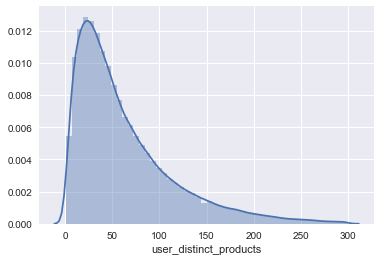

In [15]:
sns.distplot(users[users['user_distinct_products'] < 300]['user_distinct_products'])

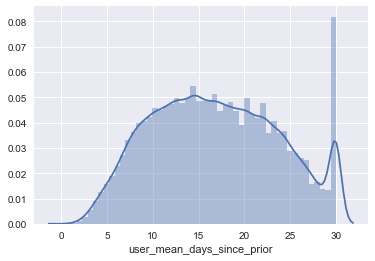

In [16]:
sns.distplot(users['user_mean_days_since_prior'])

## Product Features
prod_orders: How many times this product has been ordered  
prod_reorder_probability: Probabability that a pruduct will be reordered after ifrst purchase  
prod_reorder_ratio

In [4]:
# sort orders and products to get the rank or the reorder frequency
prdss = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prdss['product_time'] = prdss.groupby(['user_id', 'product_id']).cumcount()+1

# getting products ordered first and second times to calculate probability later
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]
del sub1, sub2, prdss
prd.head()

,product_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,1,1852,0.385475,0.613391
1,2,90,0.102564,0.133333
2,3,277,0.486486,0.732852
3,4,329,0.351648,0.446809
4,5,15,0.666667,0.600000


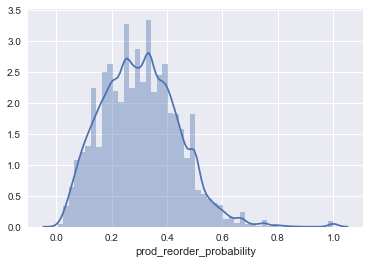

In [9]:
sns.distplot(prd['prod_reorder_probability'])

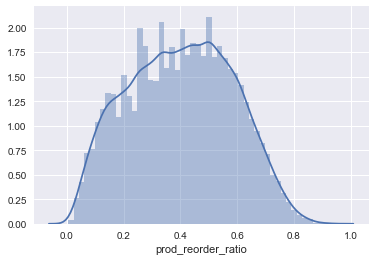

In [10]:
sns.distplot(prd['prod_reorder_ratio'])

## User/Product combination Features
up_orders: How many times this user orderd this product    
up_first_order/up_last_order: first/last time a user ordered this item  
up_average_cart_position: the average add to cart order of the item from this user's orders  
up_order_rate: the percent of user buying this in all his/her orders
up_orders_since_last_order: how many orders bewteen the last buy of this product

In [5]:
# merging orders and products and grouping by user and product and calculating features for the user/product combination
data = orders_products.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merging previous data with users
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
data = data.merge(train_orders[['user_id', 'product_id', 'reordered']],
                  how = 'left', on = ['user_id', 'product_id'])
data = data.merge(products, on = 'product_id')


,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,user_orders,...,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,aisle_id,department_id
0,1,196,10,1,10,1.400000,35791,0.5825,0.77648,10,...,18,5.900000,1187899,1,14,1.000000,0,1.0,77,7
1,15,196,5,15,22,2.200000,35791,0.5825,0.77648,22,...,13,3.272727,2161313,2,7,0.227273,0,NaN,77,7
2,19,196,3,2,7,6.333333,35791,0.5825,0.77648,9,...,133,22.666667,1735923,2,8,0.333333,2,NaN,77,7
3,21,196,1,10,10,2.000000,35791,0.5825,0.77648,33,...,102,6.212121,1854765,1,28,0.030303,23,NaN,77,7
4,31,196,2,10,17,15.500000,35791,0.5825,0.77648,20,...,190,14.950000,280888,2,18,0.100000,3,NaN,77,7


In [6]:
df = data.merge(orders_products[['user_id', 'product_id',"order_dow", "order_hour_of_day"]],
                  how = 'left', on = ['user_id', 'product_id'])
df.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,user_orders,...,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,aisle_id,department_id,order_dow,order_hour_of_day
0,1,196,10,1,10,1.4,35791,0.5825,0.77648,10,...,1187899,1,14,1.0,0,1.0,77,7,2,8
1,1,196,10,1,10,1.4,35791,0.5825,0.77648,10,...,1187899,1,14,1.0,0,1.0,77,7,3,7
2,1,196,10,1,10,1.4,35791,0.5825,0.77648,10,...,1187899,1,14,1.0,0,1.0,77,7,3,12
3,1,196,10,1,10,1.4,35791,0.5825,0.77648,10,...,1187899,1,14,1.0,0,1.0,77,7,4,7
4,1,196,10,1,10,1.4,35791,0.5825,0.77648,10,...,1187899,1,14,1.0,0,1.0,77,7,4,15


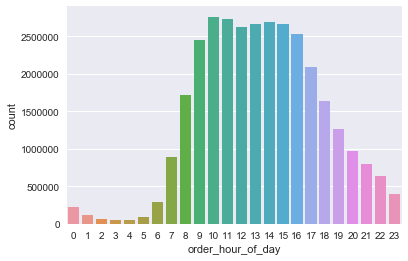

In [10]:
sns.countplot(df['order_hour_of_day'])

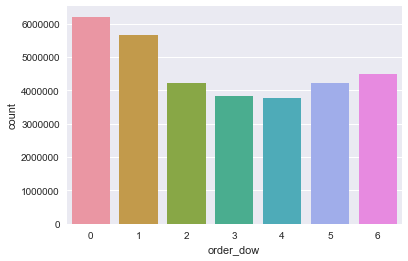

In [11]:
sns.countplot(df['order_dow'])